In [30]:
import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn import cluster
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%run -i ../notebooks/functions.py

In [4]:
master_df = pd.read_csv('../processed_data/master.csv')

In [5]:
X = master_df.iloc[:, 2:]
lat_lng = master_df.iloc[:, 0:2]

In [6]:
#Scaling the data
scaler = StandardScaler()
#fit scaler to data
scaler.fit(X.values)

#transform and save into new dataframe
X_std = pd.DataFrame(scaler.transform(X.values), 
                                columns = X.columns)
    
X_std.head()

,Population,traffic,ped_traffic,count_x,acres,count_y,PARKING LOTS AND GARAGES,NON-PUBLIC K-12 SCHOOLS,HOSPITALS AND CLINICS,PUBLIC K-12 SCHOOLS,"STREETSCAPES, PLAZAS, AND MALLS",BUS DEPOTS AND TERMINALS,MUSEUMS,COLLEGES OR UNIVERSITIES
0,-0.837351,-0.637258,-0.379571,-0.152898,0.834789,-0.197862,0.308110,-0.412739,-1.065555,-1.009000,-0.633610,0.131304,0.170919,-0.453408
1,-0.636818,-0.119831,-0.379571,-0.152898,1.579880,-0.214343,-0.530724,-0.565171,-0.716633,-1.009000,-0.633610,-0.370740,-0.413805,-0.453408
2,-0.952083,0.069818,-0.379571,-1.572667,0.461823,-0.214343,-0.635578,-0.717602,-1.065555,-0.797435,-0.972114,0.131304,0.170919,-0.453408
3,-1.886269,-0.795459,-0.379571,-1.572667,-0.392163,-0.230824,-0.688006,-0.870034,-1.065555,-1.643693,-0.972114,-0.370740,-0.413805,-0.453408
4,-0.054161,0.075751,-0.379571,-0.152898,0.765566,-0.230824,-0.583151,-0.107875,-1.065555,-0.374306,-0.633610,-0.370740,-0.413805,-0.453408


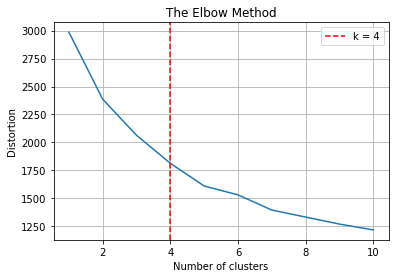

<Figure size 432x288 with 0 Axes>

In [97]:
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X_std) >= i:
        model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10)
        model.fit(X_std)
        distortions.append(model.inertia_)

k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))

fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()
plt.savefig('../figures/elbow-method.png')

In [8]:
k = 5
model = cluster.KMeans(n_clusters=k, init='k-means++')
## clustering
dtf_X = X_std.copy()
dtf_X["cluster"] = model.fit_predict(X_std)

## add clustering info to the original dataset
X_std[["cluster"]] = dtf_X[["cluster"]]

In [9]:
df_list = []
X_plt = pd.concat([lat_lng, X_std], axis=1)
#for each cluster seperate from master dataframe and append to list
for i in range(0, k):
    df_list.append(X_plt.loc[X_plt['cluster'] == i])

X_plt

,NTA_lat,NTA_long,Population,traffic,ped_traffic,count_x,acres,count_y,PARKING LOTS AND GARAGES,NON-PUBLIC K-12 SCHOOLS,HOSPITALS AND CLINICS,PUBLIC K-12 SCHOOLS,"STREETSCAPES, PLAZAS, AND MALLS",BUS DEPOTS AND TERMINALS,MUSEUMS,COLLEGES OR UNIVERSITIES,cluster
0,40.525528,-74.233554,-0.837351,-0.637258,-0.379571,-0.152898,0.834789,-0.197862,0.308110,-0.412739,-1.065555,-1.009000,-0.633610,0.131304,0.170919,-0.453408,3
1,40.528645,-74.187734,-0.636818,-0.119831,-0.379571,-0.152898,1.579880,-0.214343,-0.530724,-0.565171,-0.716633,-1.009000,-0.633610,-0.370740,-0.413805,-0.453408,3
2,40.540334,-74.207828,-0.952083,0.069818,-0.379571,-1.572667,0.461823,-0.214343,-0.635578,-0.717602,-1.065555,-0.797435,-0.972114,0.131304,0.170919,-0.453408,3
3,40.545779,-74.128351,-1.886269,-0.795459,-0.379571,-1.572667,-0.392163,-0.230824,-0.688006,-0.870034,-1.065555,-1.643693,-0.972114,-0.370740,-0.413805,-0.453408,3
4,40.551860,-74.150890,-0.054161,0.075751,-0.379571,-0.152898,0.765566,-0.230824,-0.583151,-0.107875,-1.065555,-0.374306,-0.633610,-0.370740,-0.413805,-0.453408,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,40.880937,-73.836641,-0.333251,-0.564161,-0.379571,-0.152898,-0.315885,-0.164899,-0.111307,0.196989,-0.542172,0.471951,-0.972114,-0.370740,-0.413805,-0.453408,3
191,40.882156,-73.858949,0.872737,0.807255,-0.379571,-0.152898,0.155018,-0.214343,-0.583151,0.044557,-0.018788,0.471951,-0.295106,0.131304,-0.413805,-0.453408,4
192,40.882406,-73.910667,-0.529240,-0.440731,0.379388,1.266871,0.079445,-0.230824,0.098402,-0.565171,-0.193249,0.683516,0.381902,-0.370740,-0.413805,-0.453408,4
193,40.897931,-73.852216,0.025162,0.149258,-0.379571,-0.152898,-0.459243,-0.148417,-0.216161,-0.260307,0.155673,-0.162742,-0.633610,-0.370740,-0.413805,-0.453408,3


In [10]:
#zip each clustered dataframe in the list
cluster_dfs = llz_set(df_list)

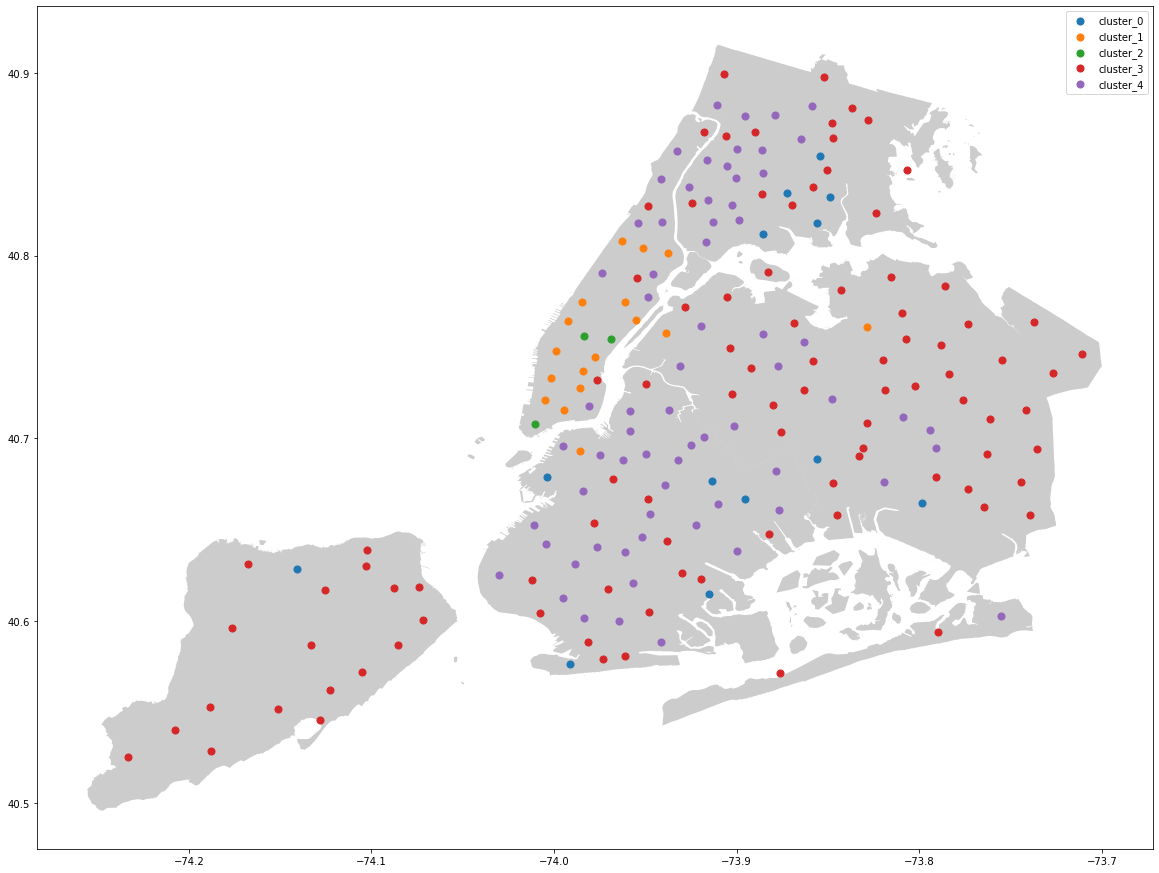

In [99]:
# Import NYC Neighborhood Shape Files
fig,ax=plt.subplots(figsize=(20,20))
boroughs = gpd.read_file(geoplot.datasets.get_path('nyc_boroughs'))
boroughs.plot(ax=ax,alpha=0.4,color="grey")

#loop through each cluster
for i in range(len(cluster_dfs)):
    cluster_dfs[i].plot(ax = ax, markersize = 50, marker = 'o', label = f"cluster_{i}")
plt.legend()
plt.savefig('../figures/first_clustering.png')

In [12]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
pca = PCA(2)
principalComponents = pca.fit_transform(X_std)
PCA_components = pd.DataFrame(principalComponents)

In [19]:
km = KMeans(n_clusters=5, n_init=1000)
y_km = km.fit_predict(principalComponents)

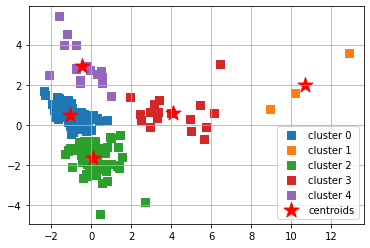

In [20]:
plot_clusters(principalComponents, y_km, plt_cluster_centers= True)

In [21]:
def plot_dendrogram(X,method ='ward'):
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.title("Dendrogram")
    plt.ylabel("Euclidean distances")
    plt.xlabel('Points')
    plt.show()

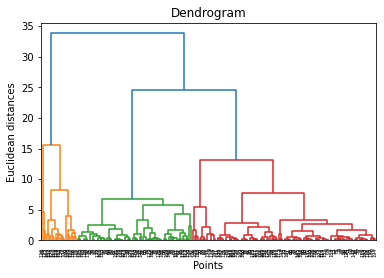

In [28]:
plot_dendrogram(PCA_components)